In [2]:
import pandas as pd
import csv

# Daten importieren
Die verwendeten Datensets beinhalten die Informationen der täglichen Handelspreise der malaysischen Goldbarrenmünze Kijang Emas mit 689 Beobachtungen seit 2018 bis Oktober 2020.

In [3]:
df = pd.read_excel ('kijangemas_quelle.xlsx')
print (df)
print(df.columns.ravel())

          Date  1 oz Sell  1 oz Buy  1/2 oz Sell  1/2 oz Buy  1/4 oz Sell  \
0   2018-01-03     5632.0    5415.0       2869.0      2708.0       1461.0   
1   2018-01-04     5579.0    5362.0       2842.0      2681.0       1447.0   
2   2018-01-05     5608.0    5391.0       2857.0      2696.0       1455.0   
3   2018-01-08     5585.0    5371.0       2845.0      2685.0       1449.0   
4   2018-01-09     5592.0    5377.0       2849.0      2688.0       1451.0   
..         ...        ...       ...          ...         ...          ...   
684 2020-10-23     8372.0    8047.0       4265.0      4023.0       2172.0   
685 2020-10-26     8386.0    8044.0       4272.0      4022.0       2176.0   
686 2020-10-27     8413.0    8086.0       4286.0      4043.0       2183.0   
687 2020-10-28     8424.0    8087.0       4292.0      4043.0       2186.0   
688 2020-10-30     8245.0    7915.0       4200.0      3957.0       2139.0   

     1/4 oz Buy  
0        1354.0  
1        1341.0  
2        1348.0  
3  

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In dieser Arbeit wird der Verkaufspreis für 1 oz Gold betrachtet

In [5]:
timestamp, selling = [], []  
timestamp = pd.DatetimeIndex(df['Date']).date
selling = selling = df["1 oz Sell"]
len(timestamp), len(selling)

(689, 689)

# Stationarität Analysis
Die Beobachtungen in einer stationären Zeitreihe sind nicht zeitabhängig.

Zeitreihen sind stationär, wenn sie keine Trend- oder Saisoneffekte haben. Summary statistics wie der Mittelwert oder die Varianz der Beobachtungen, die für die Zeitreihen berechnet wurden, sind über die Zeit konsistent.

Wenn eine Zeitreihe stationär ist, kann die Modellierung einfacher sein. Statistische Modellierungsmethoden setzen voraus oder erfordern, dass die Zeitreihen stationär sind, um effektiv zu sein.

2 Methoden, um  die Stationarität zu überprüfen, werden in dieser Arbeit implementiert: Summary statistic und Augmented Dickey-Fuller test

#### 1. Summary Statistics : Mean, Variance

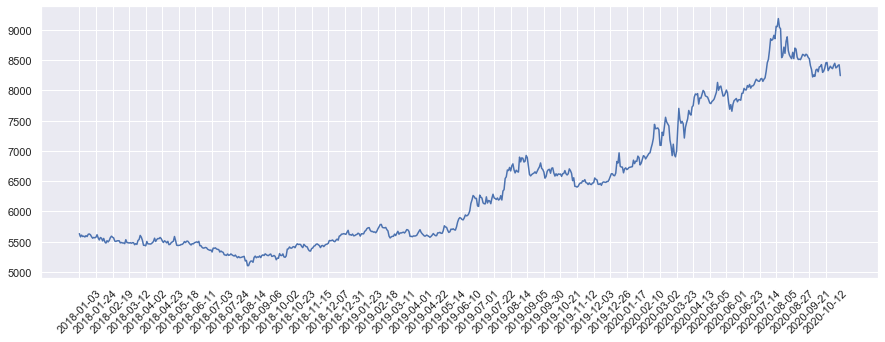

In [6]:
plt.figure(figsize = (15, 5))
plt.plot(selling)
plt.xticks(np.arange(len(timestamp))[::15], timestamp[::15], rotation = '45')
plt.show()

Hier ist es grob ersichtlich dass ab Anfang 2019 ein Trend gibt. Eine schnelle Überprüfung, um festzustellen, ob die Zeitreihen nicht stationär sind, ist der Mittelwert und die Varianz zu berechnet.

Wir können die Zeitreihen in zwei (oder mehr) Partitionen aufteilen und den Mittelwert und die Varianz jeder Gruppe vergleichen. Wenn sie sich unterscheiden und der Unterschied statistisch signifikant ist, ist die Zeitreihe wahrscheinlich nicht stationär.

In [7]:
X = selling.values
split = round(len(X) / 2)
Half1, Half2 = X[0:split], X[split:]
time1, time2 = timestamp[0:split], timestamp[split:]
meanH1, meanH2 = Half1.mean(), Half2.mean()
varH1, varH2 = Half1.var(), Half2.var()
print('meanH1=%f, meanH2=%f' % (meanH1, meanH2))
print('varianceH1=%f, varianceH2=%f' % (varH1, varH2))

meanH1=5494.976744, meanH2=7290.466667
varianceH1=22011.400622, varianceH2=739592.440193


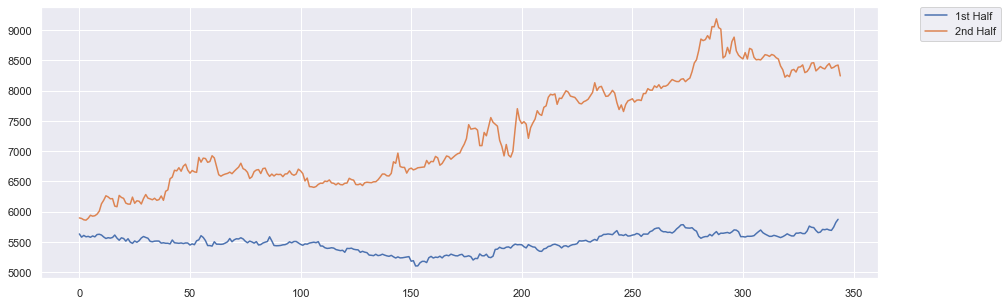

In [8]:
plt.figure(figsize = (15, 5))
plt.plot(Half1, label="1st Half")
plt.plot(Half2, label= "2nd Half")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Nach der Berechnung von Mittelwert und Varianz können wir sehen dass es eine signifikante Unterschied im Wert gibt. 
Im Plot ist es ersichtlich dass die Linie von der ersten Hälfte flach aussieht während die von der zweiten Hälfte steigt.

In [9]:
X = selling.values
split = round(len(X) / 4)
Q1, Q2, Q3, Q4 = X[0:split], X[split: 2*split], X[2*split: 3*split], X[3*split:]
meanQ1, meanQ2, meanQ3, meanQ4 = Q1.mean(), Q2.mean(), Q3.mean(), Q4.mean()
varQ1, varQ2, varQ3, varQ4 = Q1.var(), Q2.var(), Q3.var(), Q4.var()
print('meanQ1=%f, meanQ2=%f, meanQ3=%f, meanQ4=%f' % (meanQ1, meanQ2, meanQ3, meanQ4))
print('varianceQ1=%f, varianceQ2=%f, varianceQ3=%f, varianceQ4=%f' % (varQ1, varQ2, varQ3, varQ4))

meanQ1=5431.558140, meanQ2=5558.395349, meanQ3=6529.476744, meanQ4=8047.057803
varianceQ1=15445.048945, varianceQ2=20533.913467, varianceQ3=68845.551785, varianceQ4=258273.800127


In dieser Arbeit sollen wir die nächste 61 Tage vorherzusagen. Da die Datei unterschiedliche Eigentschaft hat (die Erste Stationär und die Zweite ein Trend hat) werden die aufgeteilte Daten separat betrachtet und am Ende das Ergebnis vergliechen. Da die Zeitreihe der zweite Datei nicht stationär ist, werden wir die Datei manipulieren indem die Differenzierung benutzt wird. 

Aber zuerst gucken wir was der Augmented Dickey-Fuller test sagt

#### 2. Statistical Test : Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller
gesamt = selling.values
resultgesamt = adfuller(gesamt)
result1Half = adfuller(Half1)
result2Half = adfuller(Half2)
print('ADF Statistic gesamt: %f' % resultgesamt[0])
print('p-value gesamt: %f' % resultgesamt[1])
print('Critical Values gesamt:')
for key, value in resultgesamt[4].items():
	print('\t%s: %.3f' % (key, value))
print('ADF Statistic Half1: %f' % result1Half[0])
print('p-value: %f' % result1Half[1])
print('Critical Values:')
for key, value in result1Half[4].items():
	print('\t%s: %.3f' % (key, value))
print('ADF Statistic Half2: %f' % result2Half[0])
print('p-value: %f' % result2Half[1])
print('Critical Values:')
for key, value in result2Half[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic gesamt: 0.348804
p-value gesamt: 0.979476
Critical Values gesamt:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic Half1: -0.374526
p-value: 0.914266
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
ADF Statistic Half2: -1.307777
p-value: 0.625607
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


Laut der p-values sind aber alle 3 Dateien (gesamt, 1st Half und 2nd Half) nicht stationär ist
# Datei Manipulation
Die Differenzierung ist eine Methode zum Transformieren eines Zeitreihendatensatzes. Die Differenzierung erfolgt durch Subtrahieren der vorherigen Beobachtung von der aktuellen Beobachtung. Eine Differenzierung kann dazu beitragen, den Mittelwert der Zeitreihen zu stabilisieren, indem Änderungen im Pegel einer Zeitreihe entfernt werden und so Trend und Saisonalität eliminiert (oder reduziert) werden. Page 215, Forecasting: principles and practice.


In [63]:
dfges = pd.DataFrame({'timestamp': timestamp, 'selling': selling})
df1 = pd.DataFrame({'timestamp1': time1, 'selling1': Half1})
df2 = pd.DataFrame({'timestamp2': time2, 'selling2': Half2})
gesdiff = dfges.diff()
diff2 = df2.diff()
sellges = gesdiff["selling"].values
sell2 = diff2["selling2"].values
sellges[0] = 0
sell2[0] = 0

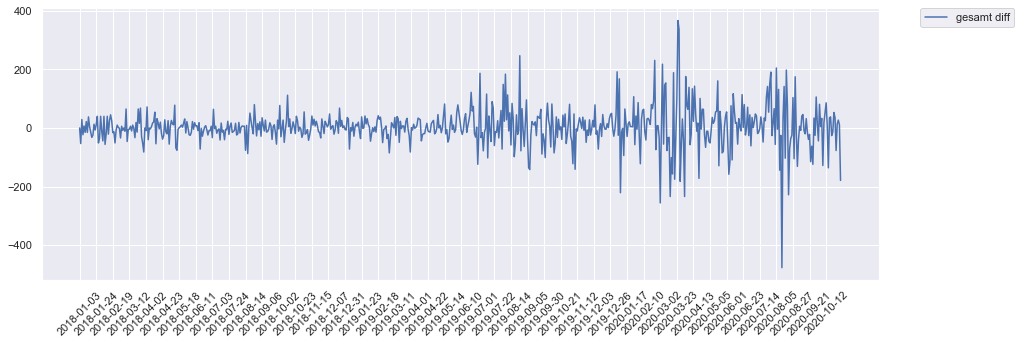

In [12]:
plt.figure(figsize = (15, 5))
plt.plot(gesdiff["selling"], label = "gesamt diff")
plt.xticks(np.arange(len(timestamp))[::15], timestamp[::15], rotation = '45')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [13]:
resultdiffges = adfuller(sellges)
print('ADF Statistic: %f' % resultdiffges[0])
print('p-value: %f' % resultdiffges[1])
print('Critical Values:')
for key, value in resultdiffges[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.693043
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


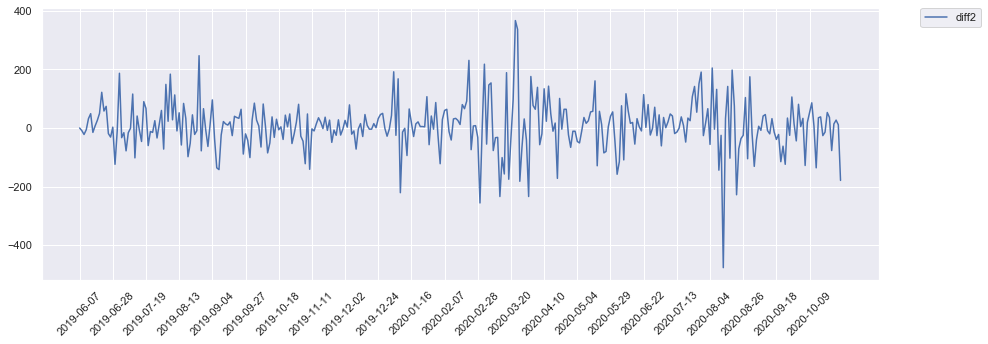

In [14]:
plt.figure(figsize = (15, 5))
plt.plot(diff2["selling2"], label = "diff2")
plt.xticks(np.arange(len(time2))[::15], time2[::15], rotation = '45')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [15]:
resultdiff2 = adfuller(sell2)
print('ADF Statistic: %f' % resultdiff2[0])
print('p-value: %f' % resultdiff2[1])
print('Critical Values:')
for key, value in resultdiff2[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.512078
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


# Verteilungsanalyse

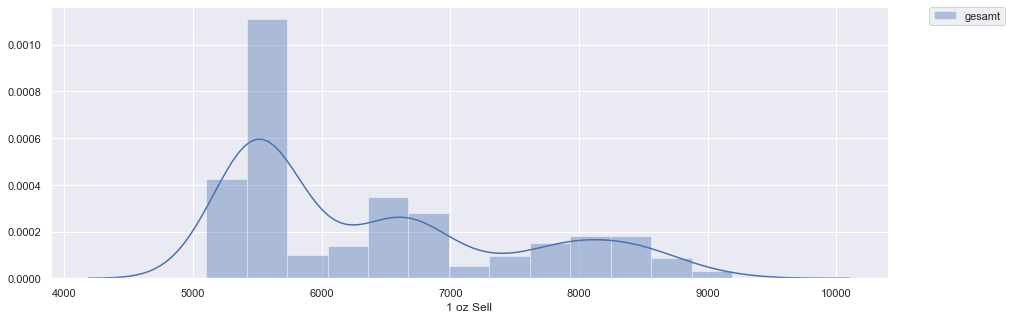

In [16]:
plt.figure(figsize = (15, 5))
sns.distplot(selling, label="gesamt")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

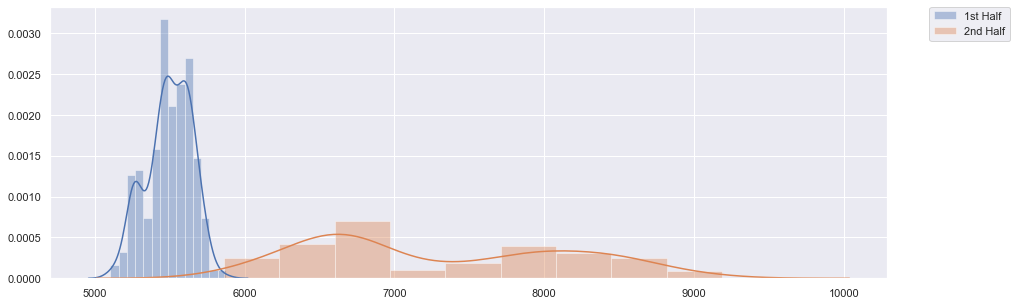

In [17]:
plt.figure(figsize = (15, 5))
sns.distplot(Half1, label="1st Half")
sns.distplot(Half2, label= "2nd Half")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

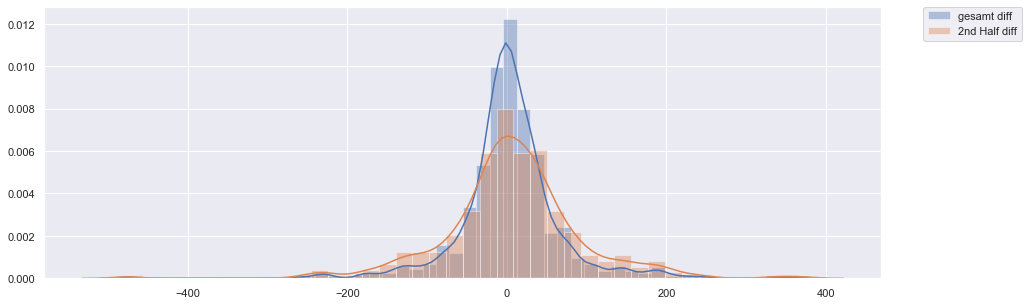

In [18]:
plt.figure(figsize = (15, 5))
sns.distplot(sellges, label= "gesamt diff")
sns.distplot(sell2, label= "2nd Half diff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

We clearly see the bell curve-like shape of the Gaussian distribution in both of the data 

->
### Wir werden in dieser Arbeit 2 Dateien benutzen und das Ergebnis vergleichen
1. Gesamt mit Differenzierung 
2. Gesamt ohne Differenzierung

# lagging analysis
A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation.

In [22]:
dfges #Data Frame der gesamten Datei ohne Differenzierung
gesdiff #Data Frame der gesamten Datei mit Differenzierung

,timestamp,selling
0,NaN,0.0
1,"1 day, 0:00:00",-53.0
2,"1 day, 0:00:00",29.0
3,"3 days, 0:00:00",-23.0
4,"1 day, 0:00:00",7.0
...,...,...
684,"1 day, 0:00:00",-77.0
685,"3 days, 0:00:00",14.0
686,"1 day, 0:00:00",27.0
687,"1 day, 0:00:00",11.0


In [31]:
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = start - 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += skip
        df = pd.concat([df, dfn], axis = 1, join_axes = [df.index])
    return df

# Shifted and moving average are not same.

moving average: the moving average is commonly used with time series to smooth random short-term variations and to highlight other components such as trend, season or cycle present in the data. The moving average is also knows as rolling mean, is calculated by averaging data of the time series withing k periods of time. rolling(n).mean() for unit k means the sum of (unit_k + unit_k-1 + ... + unit_k-n) / n

shifted:

lag:

# why we lagged or shifted to certain units?
Virals took some time, impacts took some time, same goes to price lot / unit.

Now I want to lag for until 12 units, start at 4 units shifted, skip every 2 units.

In [34]:
df_crosscorrelated = df_shift(
    dfges, lag = 12, start = 4, skip = 2, rejected_columns = ['timestamp']
)
df_crosscorrelated['ma7'] = df_crosscorrelated['selling'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['selling'].rolling(14).mean()
df_crosscorrelated['ma21'] = df_crosscorrelated['selling'].rolling(21).mean()

C:\Users\zahra\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


In [42]:
df_crosscorrelateddiff = df_shift(
    gesdiff, lag = 12, start = 4, skip = 2, rejected_columns = ['timestamp']
)
df_crosscorrelateddiff['ma7'] = df_crosscorrelateddiff['selling'].rolling(7).mean()
df_crosscorrelateddiff['ma14'] = df_crosscorrelateddiff['selling'].rolling(14).mean()
df_crosscorrelateddiff['ma21'] = df_crosscorrelateddiff['selling'].rolling(21).mean()

C:\Users\zahra\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


In [36]:
df_crosscorrelated.head(21)

,timestamp,selling,selling_4,selling_6,selling_8,selling_10,selling_12,ma7,ma14,ma21
0,2018-01-03,5632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-04,5579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-05,5608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-08,5585.0,5632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-09,5592.0,5579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-10,5577.0,5608.0,5632.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-11,5599.0,5585.0,5579.0,NaN,NaN,NaN,5596.000000,NaN,NaN
7,2018-01-12,5584.0,5592.0,5608.0,5632.0,NaN,NaN,5589.142857,NaN,NaN
8,2018-01-15,5622.0,5577.0,5585.0,5579.0,NaN,NaN,5595.285714,NaN,NaN
9,2018-01-16,5627.0,5599.0,5592.0,5608.0,5632.0,NaN,5598.000000,NaN,NaN


In [43]:
df_crosscorrelateddiff.head(21)

,timestamp,selling,selling_4,selling_6,selling_8,selling_10,selling_12,ma7,ma14,ma21
0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"1 day, 0:00:00",-53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"1 day, 0:00:00",29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"3 days, 0:00:00",-23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"1 day, 0:00:00",7.0,-53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"1 day, 0:00:00",-15.0,29.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,"1 day, 0:00:00",22.0,-23.0,-53.0,NaN,NaN,NaN,-4.714286,NaN,NaN
7,"1 day, 0:00:00",-15.0,7.0,29.0,0.0,NaN,NaN,-6.857143,NaN,NaN
8,"3 days, 0:00:00",38.0,-15.0,-23.0,-53.0,NaN,NaN,6.142857,NaN,NaN
9,"1 day, 0:00:00",5.0,22.0,7.0,29.0,0.0,NaN,2.714286,NaN,NaN


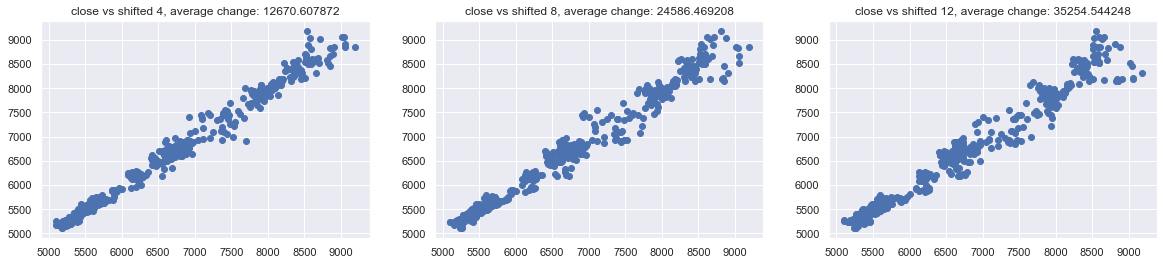

In [35]:
plt.figure(figsize = (20, 4))
plt.subplot(1, 3, 1)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_4'])
mse = (
    (df_crosscorrelated['selling_4'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 4, average change: %f'%(mse))
plt.subplot(1, 3, 2)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_8'])
mse = (
    (df_crosscorrelated['selling_8'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 8, average change: %f'%(mse))
plt.subplot(1, 3, 3)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_12'])
mse = (
    (df_crosscorrelated['selling_12'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 12, average change: %f'%(mse))
plt.show()

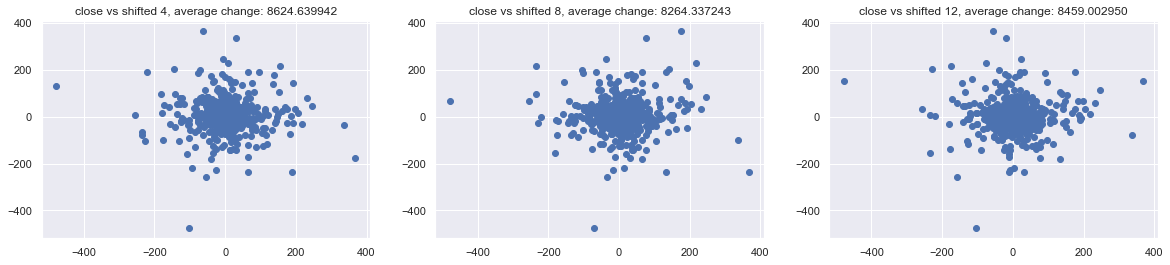

In [44]:
plt.figure(figsize = (20, 4))
plt.subplot(1, 3, 1)
plt.scatter(df_crosscorrelateddiff['selling'], df_crosscorrelateddiff['selling_4'])
mse = (
    (df_crosscorrelateddiff['selling_4'] - df_crosscorrelateddiff['selling']) ** 2
).mean()
plt.title('close vs shifted 4, average change: %f'%(mse))
plt.subplot(1, 3, 2)
plt.scatter(df_crosscorrelateddiff['selling'], df_crosscorrelateddiff['selling_8'])
mse = (
    (df_crosscorrelateddiff['selling_8'] - df_crosscorrelateddiff['selling']) ** 2
).mean()
plt.title('close vs shifted 8, average change: %f'%(mse))
plt.subplot(1, 3, 3)
plt.scatter(df_crosscorrelateddiff['selling'], df_crosscorrelateddiff['selling_12'])
mse = (
    (df_crosscorrelateddiff['selling_12'] - df_crosscorrelateddiff['selling']) ** 2
).mean()
plt.title('close vs shifted 12, average change: %f'%(mse))
plt.show()

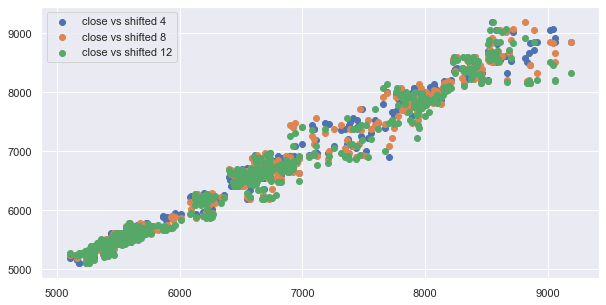

In [90]:
plt.figure(figsize = (10, 5))
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_4'],
    label = 'close vs shifted 4',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_8'],
    label = 'close vs shifted 8',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_12'],
    label = 'close vs shifted 12',
)
plt.legend()
plt.show()

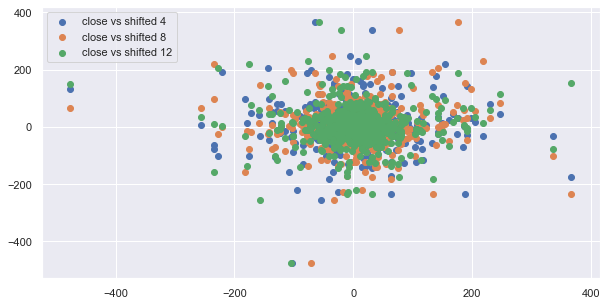

In [45]:
plt.figure(figsize = (10, 5))
plt.scatter(
    df_crosscorrelateddiff['selling'],
    df_crosscorrelateddiff['selling_4'],
    label = 'close vs shifted 4',
)
plt.scatter(
    df_crosscorrelateddiff['selling'],
    df_crosscorrelateddiff['selling_8'],
    label = 'close vs shifted 8',
)
plt.scatter(
    df_crosscorrelateddiff['selling'],
    df_crosscorrelateddiff['selling_12'],
    label = 'close vs shifted 12',
)
plt.legend()
plt.show()

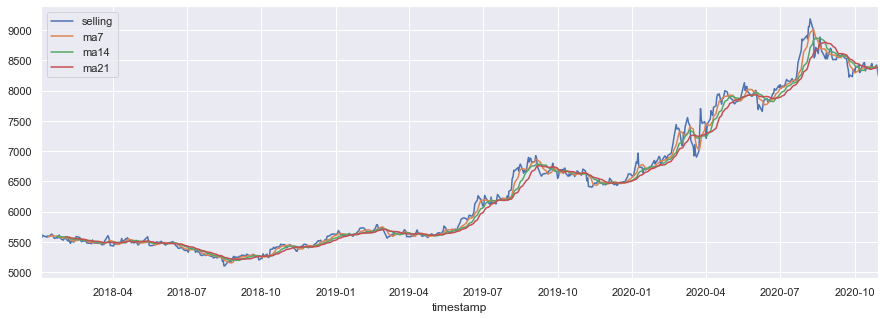

In [27]:
fig, ax = plt.subplots(figsize = (15, 5))
df_crosscorrelated.plot(
    x = 'timestamp', y = ['selling', 'ma7', 'ma14', 'ma21'], ax = ax
)

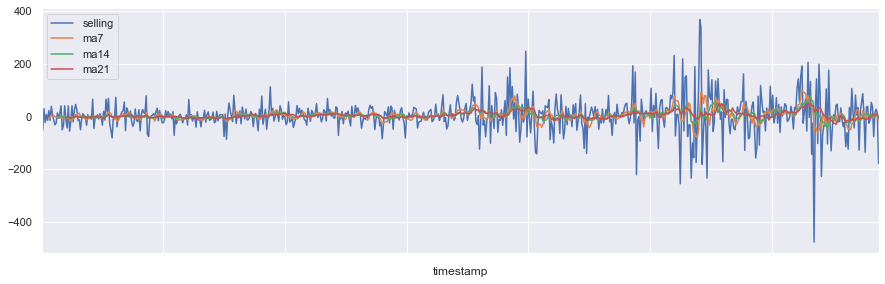

In [46]:
fig, ax = plt.subplots(figsize = (15, 5))
df_crosscorrelateddiff.plot(
    x = 'timestamp', y = ['selling', 'ma7', 'ma14', 'ma21'], ax = ax
)

As you can see, even moving average 7 already not followed sudden trending (blue line), means that, dilation rate required less than 7 days! so fast!

# How about correlation?
We want to study linear relationship between, how many days required to give impact to future sold units?

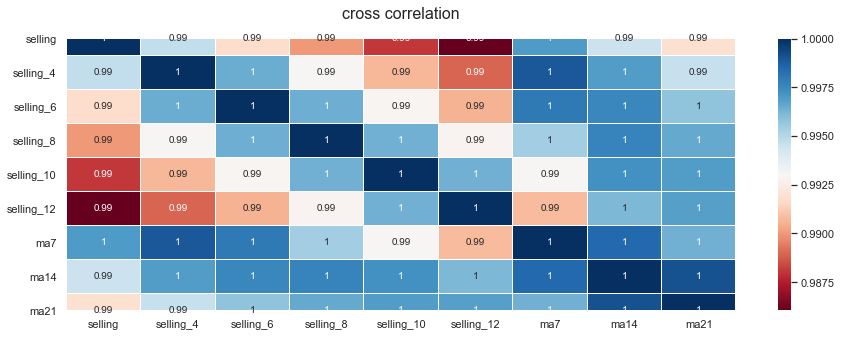

In [37]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 5))
plt.title('cross correlation', y = 1.05, size = 16)

sns.heatmap(
    df_crosscorrelated.iloc[:, 1:].corr(),
    linewidths = 0.1,
    vmax = 1.0,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

Based on this correlation map, look at selling vs selling_X,

selling_X from 4 to 12 is getting lower, means that, if today is 50 mean, next 4 days should increased by 0.995 * 50 mean, and continue.

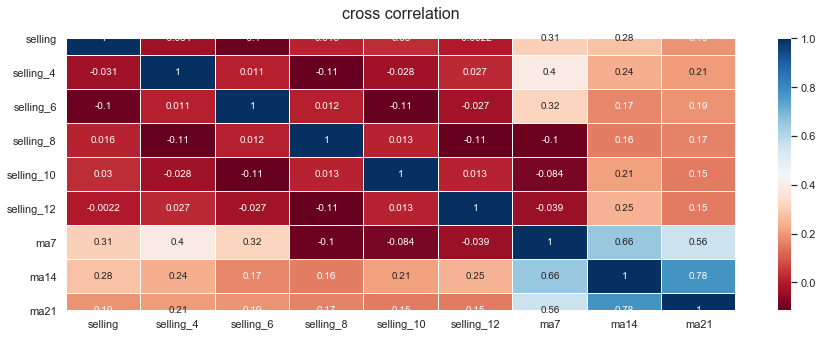

In [47]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 5))
plt.title('cross correlation', y = 1.05, size = 16)

sns.heatmap(
    df_crosscorrelateddiff.iloc[:, 1:].corr(),
    linewidths = 0.1,
    vmax = 1.0,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()


# Outliers
Simple, we can use Z-score to detect outliers, which timestamps gave very uncertain high and low value.

In [48]:
std_selling = (selling - np.mean(selling)) / np.std(selling)

In [49]:
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [53]:
outliers = detect(std_selling)
outliersdiff = detect(gesdiff.selling)

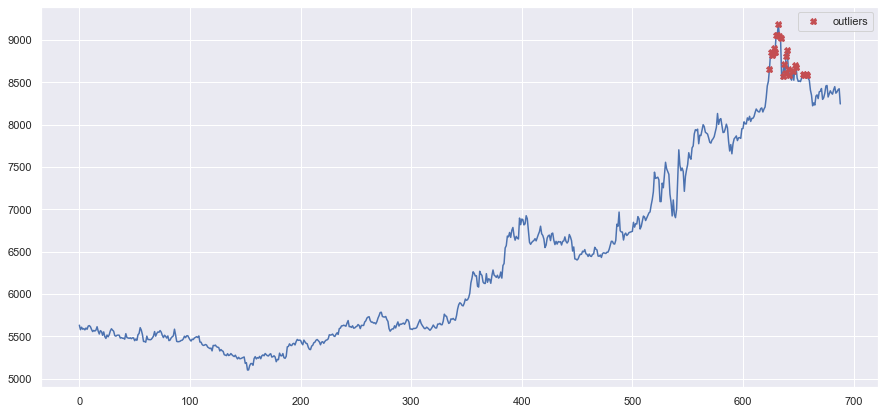

In [57]:
plt.figure(figsize = (15, 7))
plt.plot(selling)
plt.plot(
    np.arange(len(selling)),
    selling,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.legend()
plt.show()

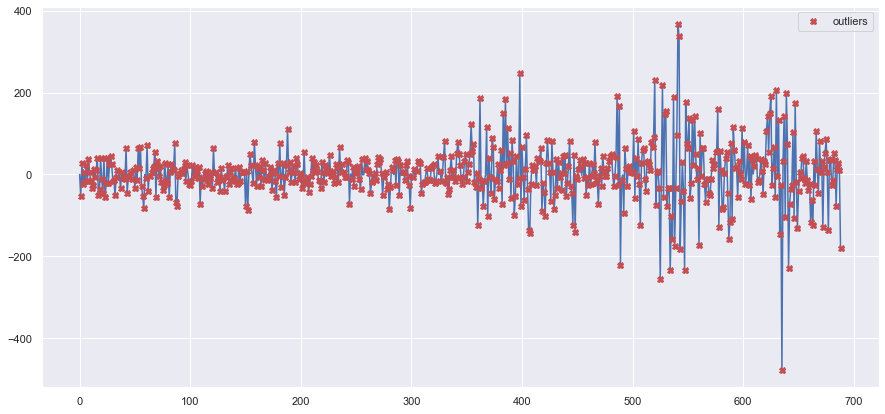

In [56]:
plt.figure(figsize = (15, 7))
plt.plot(gesdiff.selling)
plt.plot(
    np.arange(len(gesdiff.selling)),
    gesdiff.selling,
    'X',
    label = 'outliers',
    markevery = outliersdiff,
    c = 'r',
)
plt.legend()
plt.show()

# Predictive Modelling
# Lineare Regression

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
train_selling= selling[:628]
test_selling = selling[628:]

future_count = len(test_selling)
print(future_count)

61


In [60]:
%%time
linear_regression = LinearRegression().fit(
    np.arange(len(train_selling)).reshape((-1, 1)), train_selling
)
linear_future = linear_regression.predict(
    np.arange(len(train_selling) + future_count).reshape((-1, 1))
)

Wall time: 14.9 ms


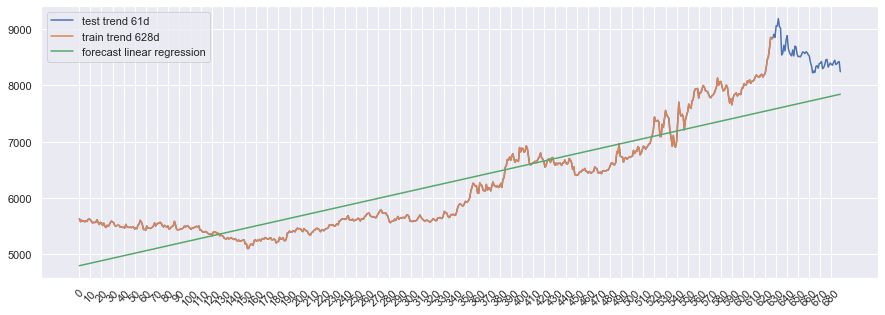

In [67]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test trend 61d')
ax.plot(train_selling, label = 'train trend 628d')
ax.plot(linear_future, label = 'forecast linear regression')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

In [64]:
train_sellingdiff= sellges[:628]
test_sellingdiff = sellges[628:]

future_countdiff = len(test_sellingdiff)
print(future_countdiff)

61


In [65]:
%%time
linear_regressiondiff = LinearRegression().fit(
    np.arange(len(train_sellingdiff)).reshape((-1, 1)), train_sellingdiff
)
linear_futurediff = linear_regressiondiff.predict(
    np.arange(len(train_sellingdiff) + future_countdiff).reshape((-1, 1))
)

Wall time: 998 µs


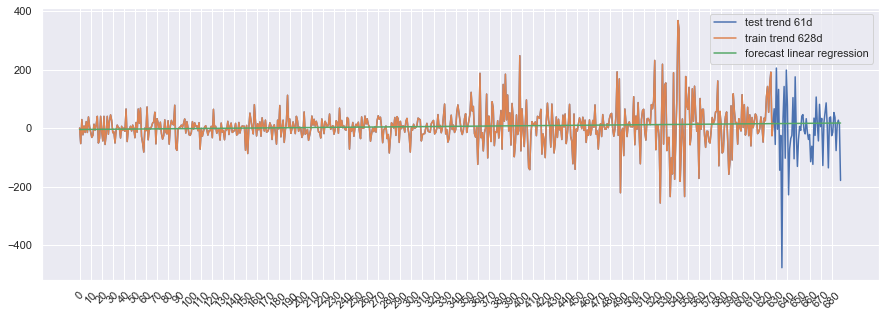

In [66]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(sellges, label = 'test trend 61d')
ax.plot(train_sellingdiff, label = 'train trend 628d')
ax.plot(linear_futurediff, label = 'forecast linear regression')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

# ----------------------------------------bis hier-------------------------------------------------

In [102]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

In [103]:
def calculate_accuracy(real, predict):
    r2 = r2_score(real, predict)
    if r2 < 0:
        r2 = 0

    def change_percentage(val): 
    # minmax, we know that correlation is between -1 and 1
        if val > 0:
            return val
        else:
            return val + 1

    pearson = pearsonr(real, predict)[0]
    spearman = spearmanr(real, predict)[0]
    pearson = change_percentage(pearson)
    spearman = change_percentage(spearman)
    return {
        'r2': r2 * 100,
        'pearson': pearson * 100,
        'spearman': spearman * 100,
    }

In [104]:
def calculate_distance(real, predict):
    mse = ((real - predict) ** 2).mean()
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [105]:
linear_cut = linear_future[: len(train_selling)]
#arima_cut = arima_future[: len(train_selling)]
#lstm_cut = lstm_future[: len(train_selling)]

80%

In [106]:
calculate_distance(train_selling, linear_cut)

{'mse': 149894.57114257725, 'rmse': 387.1622026264667}

In [107]:
calculate_accuracy(train_selling, linear_cut)

{'r2': 79.79509390216938,
 'pearson': 89.32809966755666,
 'spearman': 89.37135388529691}

20%

In [108]:
linear_cut = linear_future[len(train_selling) :]

In [109]:
calculate_distance(test_selling, linear_cut)

{'mse': 908239.6295883702, 'rmse': 953.0160699528473}

In [110]:
calculate_accuracy(test_selling, linear_cut)

{'r2': 0, 'pearson': 35.53979408778303, 'spearman': 34.925144069760115}